In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import torch.nn.functional as F
from torch.utils.data import random_split
import numpy as np
import matplotlib.pyplot as plt # Needed for visualization

In [9]:
# --- CONFIGURATION & TRANSFORMATIONS ---
print("--- Setting up Data Transformations and Loaders ---")

# Define transformations: Convert to Tensor and Normalize the 3 color channels
transform = transforms.Compose([ 
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)) # Normalizes to range [-1, 1] 
])

BATCH_SIZE = 4
EPOCHS = 5 
DOWNLOAD_ROOT = './data'
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

# --- Load CIFAR-10 Training and Test datasets ---
train_val_set = torchvision.datasets.CIFAR10(root=DOWNLOAD_ROOT, train=True, 
                                        download=True, transform=transform)
testset = torchvision.datasets.CIFAR10(root=DOWNLOAD_ROOT, train=False, 
                                       download=True, transform=transform)


# --- SPLITTING THE TRAINING DATA INTO TRAIN AND VALIDATION ---
TRAIN_SIZE = 45000 # 90% of original training data
VAL_SIZE = 5000  # 10% of original training data (50000 - 45000)

print(f"Splitting original training set (50,000) into 45,000 (Train) and 5,000 (Validation).")
train_data, val_data = random_split(train_val_set, [TRAIN_SIZE, VAL_SIZE])

# Create DataLoaders
trainloader = torch.utils.data.DataLoader(train_data, batch_size=BATCH_SIZE,
                                          shuffle=True, num_workers=2)
valloader = torch.utils.data.DataLoader(val_data, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2) # Shuffle=False for validation
testloader = torch.utils.data.DataLoader(testset, batch_size=BATCH_SIZE,
                                         shuffle=False, num_workers=2)


print(f"Data loaded! Training: {len(train_data)}, Validation: {len(val_data)}, Test: {len(testset)}")
print("-" * 50)

--- Setting up Data Transformations and Loaders ---
Files already downloaded and verified
Files already downloaded and verified
Splitting original training set (50,000) into 45,000 (Train) and 5,000 (Validation).
Data loaded! Training: 45000, Validation: 5000, Test: 10000
--------------------------------------------------


In [ ]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        # 3 input image channels (RGB), 6 output channels, 5x5 kernel
        self.conv1 = nn.Conv2d(3, 6, 5) # first convolutional layer
        self.pool = nn.MaxPool2d(2, 2)  # 2x2 max pooling layer
        # 6 input channels (from conv1), 16 output channels, 5x5 kernel
        self.conv2 = nn.Conv2d(6, 16, 5)
        
        # Fully connected layers (FC): Input size calculated from the flattened feature maps (16 * 5 * 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120) # first FC layer, linear activation
        self.fc2 = nn.Linear(120, 84)         # second FC layer, linear activation
        self.fc3 = nn.Linear(84, 10)          # 10 is the number of classes

    def forward(self, x):
        import torch.nn.functional as F
        # -> Convolution -> ReLU -> Pooling
        x = self.pool(F.relu(self.conv1(x))) # Apply Conv1, ReLU activation, then MaxPool
        x = self.pool(F.relu(self.conv2(x))) # Apply Conv2, ReLU activation, then MaxPool
        
        # Flatten the feature tensor into a 1D vector for the Fully Connected (FC) layers
        x = torch.flatten(x, 1) 
        
        # Fully Connected Layers
        x = F.relu(self.fc1(x)) # First FC layer with ReLU activation
        x = F.relu(self.fc2(x)) # Second FC layer with ReLU activation
        x = self.fc3(x) # Output layer (no activation here, CrossEntropyLoss handles it)
        return x

net = Net()

In [ ]:
# --- 3. LOSS & OPTIMIZER DEFINITION ---
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)


# --- 4. TRAINING LOOP ---
print("\n--- Starting Training ---")
print(f"Training for {EPOCHS} epochs with Learning Rate: {optimizer.param_groups[0]['lr']}")
print("-" * 50)

for epoch in range(EPOCHS):  
    running_loss = 0.0
    
    # Set model to training mode
    net.train() 
    # --- TRAINING STAGE ---
    for i, data in enumerate(trainloader, 0):
        inputs, labels = data

        optimizer.zero_grad()

        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        if i % 2000 == 1999:
            # Print training loss every 2000 batches
            print(f'Epoch [{epoch + 1}/{EPOCHS}] Batch [{i + 1:5d}]: Train Loss: {running_loss / 2000:.3f}')
            running_loss = 0.0

    # --- VALIDATION STAGE (Run after each epoch) ---
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    
    # Set model to evaluation mode (disables layers like dropout)
    net.eval() 
    
    with torch.no_grad():
        for data in valloader:
            images, labels = data
            outputs = net(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()

            _, predicted = torch.max(outputs.data, 1)
            val_total += labels.size(0)
            val_correct += (predicted == labels).sum().item()

    # Calculate average validation loss and accuracy
    avg_val_loss = val_loss / len(valloader)
    val_accuracy = 100 * val_correct / val_total
    
    print(f'\n--- Epoch {epoch + 1} Summary ---')
    print(f'Validation Loss: {avg_val_loss:.4f}, Validation Accuracy: {val_accuracy:.2f}%')
    print("-" * 50)

# Final Save 
# torch.save(net.state_dict(), './cifar10_cnn_final.pth')

print('Training Complete! Model state saved.')


--- Starting Training ---
Training for 5 epochs with Learning Rate: 0.001
--------------------------------------------------
Epoch [1/5] Batch [ 2000]: Train Loss: 2.197
Epoch [1/5] Batch [ 4000]: Train Loss: 1.872
Epoch [1/5] Batch [ 6000]: Train Loss: 1.717
Epoch [1/5] Batch [ 8000]: Train Loss: 1.601
Epoch [1/5] Batch [10000]: Train Loss: 1.520

--- Epoch 1 Summary ---
Validation Loss: 1.4264, Validation Accuracy: 48.32%
--------------------------------------------------
Epoch [2/5] Batch [ 2000]: Train Loss: 1.411
Epoch [2/5] Batch [ 4000]: Train Loss: 1.371
Epoch [2/5] Batch [ 6000]: Train Loss: 1.366
Epoch [2/5] Batch [ 8000]: Train Loss: 1.340
Epoch [2/5] Batch [10000]: Train Loss: 1.304

--- Epoch 2 Summary ---
Validation Loss: 1.3056, Validation Accuracy: 54.12%
--------------------------------------------------
Epoch [3/5] Batch [ 2000]: Train Loss: 1.231
Epoch [3/5] Batch [ 4000]: Train Loss: 1.220
Epoch [3/5] Batch [ 6000]: Train Loss: 1.208
Epoch [3/5] Batch [ 8000]: Trai


--- Running Final Evaluation ---
Overall Accuracy on the 10000 test images: 58.54%
Accuracy of plane : 78.40%
Accuracy of car   : 82.40%
Accuracy of bird  : 46.80%
Accuracy of cat   : 26.10%
Accuracy of deer  : 59.30%
Accuracy of dog   : 36.90%
Accuracy of frog  : 82.80%
Accuracy of horse : 51.90%
Accuracy of ship  : 63.10%
Accuracy of truck : 57.70%

--- Qualitative Prediction Check (First Batch) ---
GroundTruth:  cat   ship  ship  plane
Predicted:    cat   car   car   plane


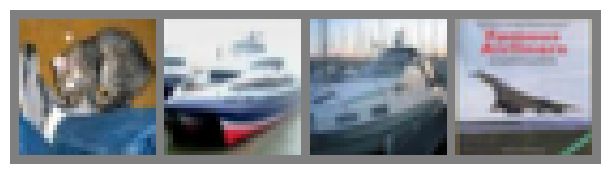

In [ ]:
# --- EVALUATION ANALYSIS ---

def run_analysis(net, testloader, classes):
    """Performs qualitative and quantitative analysis on the final model."""
    
    # --- 5.1 Quantitative Evaluation (Overall Accuracy) ---
    correct = 0
    total = 0
    class_correct = list(0. for i in range(10))
    class_total = list(0. for i in range(10))

    print("\n--- Running Final Evaluation ---")
    
    with torch.no_grad():
        for data in testloader:
            images, labels = data
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            
            # Overall Accuracy
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            
            # Per-Class Accuracy
            c = (predicted == labels).squeeze()
            for i in range(len(labels)):
                label = labels[i]
                class_correct[label] += c[i].item() 
                class_total[label] += 1

    print(f'Overall Accuracy on the 10000 test images: {100 * correct / total:.2f}%')
    
    # Per-Class Accuracy Report
    for i in range(10):
        if class_total[i] > 0:
            print(f'Accuracy of {classes[i]:5s} : {100 * class_correct[i] / class_total[i]:.2f}%')

    # --- 5.2 Qualitative Prediction Analysis ---
    # Function to display an image
    def imshow(img):
        img = img / 2 + 0.5     # Un-normalize
        npimg = img.numpy()
        plt.figure(figsize=(8,2))
        plt.imshow(np.transpose(npimg, (1, 2, 0)))
        plt.axis('off')
        plt.show()

    # Get a batch of images from the test set for visualization
    dataiter = iter(testloader)
    images, labels = next(dataiter)

    # Run the batch through the trained model
    with torch.no_grad():
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)

    print('\n--- Qualitative Prediction Check (First Batch) ---')
    print('GroundTruth: ', ' '.join(f'{classes[labels[j]]:5s}' for j in range(4)))
    print('Predicted:   ', ' '.join(f'{classes[predicted[j]]:5s}' for j in range(4)))

    # Display the images visually
    imshow(torchvision.utils.make_grid(images))

# Run the analysis after training finishes
run_analysis(net, testloader, classes)